In [16]:
import torch
import numpy as np
from torch.utils.data import DataLoader
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
import model as dl
import joblib
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [17]:
def test(i, loader, neural_network):
    acc = 0
    results_sum = []
    labels_test_sum = []
    results_PR_sum = []
    for step, (data, labels) in enumerate(loader):
        data = data.to(device)
        labels = labels.to(device)
        # 前向传播
        outputs = neural_network(data.float())
        acc += outputs.argmax(dim=1).eq(labels).type_as(torch.FloatTensor()).mean()
        results_sum = np.append(results_sum, outputs.argmax(dim=1).cpu().numpy())
        labels_test_sum = np.append(labels_test_sum, labels.cpu().numpy())
        results_PR_sum.extend(outputs.detach().cpu().numpy())
    acc_average = acc / (step + 1)
    print("第" + str(i + 1) + "次训练测试集准确率: {:.4f}".format(acc_average))
    return acc_average, results_sum, labels_test_sum, results_PR_sum

In [18]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Input
    - cm : 计算出的混淆矩阵的值
    - classes : 混淆矩阵中每一行每一列对应的列
    - normalize : True:显示百分比, False:显示个数
    """
    # 定义一种字体属性
    font1 = {'family': 'Times New Roman',
            'weight': 'normal',
            'size': 20}
    font2 = {'family': 'Times New Roman',
            'weight': 'normal',
            'size': 18}
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.figure(num=None, figsize=(6, 6), dpi=60)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontdict=font1, y=1.05)
    plt.colorbar(shrink=0.64)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontdict=font2)
    plt.yticks(tick_marks, classes, rotation=45, fontdict=font2)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                verticalalignment="center",
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black",
                fontdict=font2)
    plt.tight_layout()
    plt.ylabel('Actual Class', fontdict=font2)
    plt.xlabel('Predict Class', fontdict=font2)
    plt.subplots_adjust(left=0.2, top=1.02, bottom=0.05)
    plt.show()

In [19]:
name = locals()
seed = 22
dl.seed_everything(seed)
model_type = 'STCGRU'
batch_size = 256
total_fold = 10  # 10折

test_acc_sum = 0
results_sum = []
labels_test_sum = []
results_PR_sum = []
# 定义脑区索引
regions = {
    "prefrontal": [0, 1, 2, 3, 10, 11, 16],
    "central": [4, 5, 17],
    "temporal": [12, 13, 14, 15],
    "parietal": [6, 7, 18],
    "occipital": [8, 9],
    "all":[]
}

# 动态获取变量值
partition = "central"

srate = "250"
for i in range(total_fold):
    test_data_combine = torch.load("EEGData/"+partition+"/TestData/test_data_"+ str(i + 1) + "_fold_with_seed_" + str(seed) + ".pth", weights_only=False)
    test_loader = DataLoader(dataset=test_data_combine,
                            batch_size=batch_size,
                            shuffle=True,
                            drop_last=False,
                            pin_memory=True,
                            num_workers=8)

    model = dl.STCGRU().to(device)
    model_loc =  "stcgru/"+partition+"/"+str(i + 1) + "_fold_model_parameter_with_seed_" + str(seed) + ".pth"
    model_dict = torch.load(model_loc,weights_only=True)
    model.load_state_dict(model_dict)
    '''测试'''
    acc_average, results, labels_test, results_PR = test(i, loader=test_loader, neural_network=model)
    results_sum = np.append(results_sum, results)
    labels_test_sum = np.append(labels_test_sum, labels_test)
    results_PR_sum.extend(results_PR)
    name['test_acc_average_' + str(i + 1)] = acc_average
    confusion_matrix_single = confusion_matrix(labels_test, results, labels=[0, 1])
    kappa_single = cohen_kappa_score(labels_test, results)
    sensitivity_single = confusion_matrix_single[0, 0] / (confusion_matrix_single[0, 0] + confusion_matrix_single[0, 1])  # 灵敏度（召回率）
    specificity_single = confusion_matrix_single[1, 1] / (confusion_matrix_single[1, 1] + confusion_matrix_single[1, 0])  # 特异度
    precision_single = confusion_matrix_single[0, 0] / (confusion_matrix_single[0, 0] + confusion_matrix_single[1, 0])  # 查准率
    F1_single = 2 * precision_single * sensitivity_single / (precision_single + sensitivity_single)  # F1值
    print(model_type + " 第%d折交叉验证测试集准确率: %.4f，kappa值：%.4f，灵敏度：%.4f，特异度：%.4f，查准率：%.4f，F1值：%.4f"
        % (i+1, acc_average, kappa_single, sensitivity_single, specificity_single, precision_single, F1_single))
for i in range(total_fold):
    if i == 0:
        test_acc_sum = name['test_acc_average_' + str(i + 1)]
    else:
        test_acc_sum = np.append(test_acc_sum, name['test_acc_average_' + str(i + 1)])
    del name['test_acc_average_' + str(i + 1)]

第1次训练测试集准确率: 0.9974
STCGRU 第1折交叉验证测试集准确率: 0.9974，kappa值：0.9928，灵敏度：0.9920，特异度：1.0000，查准率：1.0000，F1值：0.9960
第2次训练测试集准确率: 0.9987
STCGRU 第2折交叉验证测试集准确率: 0.9987，kappa值：0.9964，灵敏度：1.0000，特异度：0.9969，查准率：0.9960，F1值：0.9980
第3次训练测试集准确率: 1.0000
STCGRU 第3折交叉验证测试集准确率: 1.0000，kappa值：1.0000，灵敏度：1.0000，特异度：1.0000，查准率：1.0000，F1值：1.0000
第4次训练测试集准确率: 1.0000
STCGRU 第4折交叉验证测试集准确率: 1.0000，kappa值：1.0000，灵敏度：1.0000，特异度：1.0000，查准率：1.0000，F1值：1.0000
第5次训练测试集准确率: 0.9961
STCGRU 第5折交叉验证测试集准确率: 0.9961，kappa值：0.9893，灵敏度：0.9883，特异度：1.0000，查准率：1.0000，F1值：0.9941
第6次训练测试集准确率: 1.0000
STCGRU 第6折交叉验证测试集准确率: 1.0000，kappa值：1.0000，灵敏度：1.0000，特异度：1.0000，查准率：1.0000，F1值：1.0000
第7次训练测试集准确率: 1.0000
STCGRU 第7折交叉验证测试集准确率: 1.0000，kappa值：1.0000，灵敏度：1.0000，特异度：1.0000，查准率：1.0000，F1值：1.0000
第8次训练测试集准确率: 0.9807
STCGRU 第8折交叉验证测试集准确率: 0.9807，kappa值：0.9750，灵敏度：0.9733，特异度：1.0000，查准率：1.0000，F1值：0.9865
第9次训练测试集准确率: 0.9858
STCGRU 第9折交叉验证测试集准确率: 0.9858，kappa值：0.9751，灵敏度：0.9738，特异度：1.0000，查准率：1.0000，F1值：0.9867
第10次训练测试集准确率: 1.0000
STCGRU 第10折交叉验证测

Confusion matrix, without normalization
[[2594   19]
 [   1 3029]]


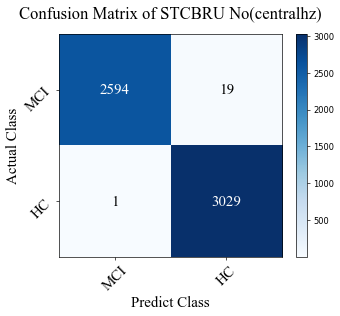

STCGRU 10折交叉验证平均测试集准确率: 0.9959 ± 0.0065，kappa值：0.9929，灵敏度：0.9927，特异度：0.9997，查准率：0.9996，F1值：0.9962


In [20]:
test_acc_final = np.sum(test_acc_sum) / total_fold
test_acc_std = float(np.std(test_acc_sum))
confusion_matrix = confusion_matrix(labels_test_sum, results_sum, labels=[0, 1])

kappa = cohen_kappa_score(labels_test_sum, results_sum)
sensitivity = confusion_matrix[0, 0] / (confusion_matrix[0, 0] + confusion_matrix[0, 1])  # 灵敏度（召回率）
specificity = confusion_matrix[1, 1] / (confusion_matrix[1, 1] + confusion_matrix[1, 0])  # 特异度
precision = confusion_matrix[0, 0] / (confusion_matrix[0, 0] + confusion_matrix[1, 0])  # 查准率
F1 = 2 * precision * sensitivity / (precision + sensitivity)  # F1值
plot_confusion_matrix(confusion_matrix, classes=['MCI', 'HC'], normalize=False,
                    title='Confusion Matrix of STCBRU No('+partition+'hz)')

print(model_type + " %d折交叉验证平均测试集准确率: %.4f ± %.4f，kappa值：%.4f，灵敏度：%.4f，特异度：%.4f，查准率：%.4f，F1值：%.4f"
    % (total_fold, test_acc_final, test_acc_std, kappa, sensitivity, specificity, precision, F1))
